In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

* Circuit simulator: https://github.com/ahkab/ahkab
* Circuit simulator 2: https://github.com/xesscorp/skidl
* SchemDraw Python lib to draw

$Tex$
* Circuit_macro
* Circuitikz
* pst-circ

# SchemDraw

In [2]:
import SchemDraw as schem
import SchemDraw.elements as e

In [3]:
nodes = [0, 1, 2, 3, 4, 5, 6]
edges = (0, 1), (1, 2), (1, 3), (0, 4), (4, 5), (4, 6)
labels = {
    0: 'paralelo',
    1: 'paralelo',
    2: 1000.0,
    3: 10000.0,
    4: 'serie',
    5: 2200.0,
    6: 2200.0
}

connections = {}

for edge in edges:
    if edge[0] not in connections:
        connections[edge[0]] = []
    connections[edge[0]].append(edge[1])

def draw(e):
    string=''
    
    if labels[e] == 'paralelo':
        string += 'paralelo('
        string += draw(connections[e][0])
        string += ', '
        string += draw(connections[e][1])
        string += ')'

    elif labels[e] == 'serie':
        string += 'serie('
        string += draw(connections[e][0])
        string += ', '
        string += draw(connections[e][1])
        string += ')'
    else:
        return str(labels[e])
    
    return string
draw(0)

'paralelo(paralelo(1000.0, 10000.0), serie(2200.0, 2200.0))'

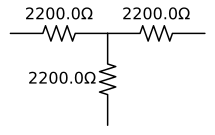

In [4]:
d = schem.Drawing()

R1 = d.add(e.RES, label='{}$\Omega$'.format(labels[5]))
R2 = d.add(e.RES, xy=R1.end, label='{}$\Omega$'.format(labels[5]))
R3 = d.add(e.RES, d='down', xy=R1.end, label='{}$\Omega$'.format(labels[5]))

d.draw()

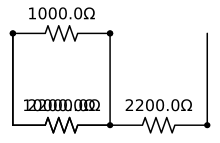

In [5]:
d = schem.Drawing()

def draw2(element):
    string = ''
    if labels[element] == 'paralelo':
        dot = d.add(e.DOT)
        draw2(connections[element][0])
        d.add(e.DOT)
        
        d.add(e.LINE, xy=dot.end, d='down')
        draw2(connections[element][1])
        d.add(e.DOT)
        d.add(e.LINE, d='up')
        
    elif labels[element] == 'serie':
        start = draw2(connections[element][0])
        end = draw2(connections[element][1])
        
        return start, end
    else:
        return d.add(e.RES, d='right', label='{}$\Omega$'.format(labels[element]))

draw2(0)

d.draw()

In [6]:
help(R1)

Help on Element in module SchemDraw.schemdraw object:

class Element(builtins.object)
 |  #--------------------------------------------------------------------
 |  # Circuit element class
 |  #--------------------------------------------------------------------
 |  
 |  Methods defined here:
 |  
 |  __init__(self, elm_def, drawing, **kwargs)
 |      Initialize the element.
 |      elm_def  : element definition dictionary (see below)
 |      drawing  : drawing to add the element to
 |      
 |      Element properties are specified using kwargs as follows.
 |      
 |      Position of element [Default = endpoint of last element]:
 |          xy     : [x,y] starting coordiante.
 |                   Element drawn in current direction and default length.
 |          endpts : [[x1,y1], [x2,y2]] start and end coordinates
 |          to     : [x,y] end coordinate
 |          tox    : x-value of end coordinate (y-value same as start)
 |          toy    : y-value of end coordinate (x-value same

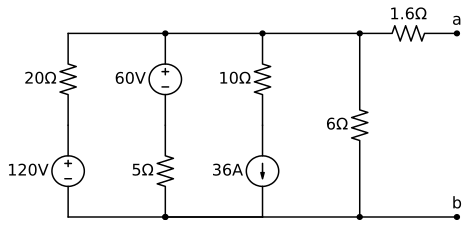

In [7]:
d = schem.Drawing()

d.push()
R1 = d.add(e.RES, d='down', label='20$\Omega$')
V1 = d.add(e.SOURCE_V, d='down', reverse=True, label='120V')
d.add(e.LINE, d='right', l=3)
d.add(e.DOT)
d.add(e.LINE, d='right', l=3)
d.pop()

d.add(e.LINE, d='right', l=3)
d.add(e.DOT)
d.add(e.SOURCE_V, d='down', label='60V', reverse=True)
d.add(e.RES, label='5$\Omega$')
d.add(e.DOT)
d.add(e.LINE, d='right', l=3)
d.add(e.SOURCE_I, d='up', label='36A')
d.add(e.RES, label='10$\Omega$')
d.add(e.DOT)
d.add(e.LINE, d='left', l=3, move_cur=False)
d.add(e.LINE, d='right', l=3)
d.add(e.DOT)
R6 = d.add(e.RES, d='down', toy=V1.start, label='6$\Omega$')
d.add(e.DOT)
d.add(e.LINE, d='left', l=3, move_cur=False)
d.add(e.RES, d='right', xy=R6.start, label='1.6$\Omega$')
d.add(e.DOT, label='a')
d.add(e.LINE, d='right', xy=R6.end)
d.add(e.DOT, label='b')

d.draw()

-------------

# NetworkX

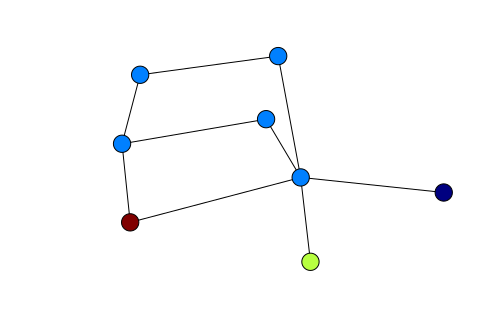

In [8]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from(
    [('A', 'B'), ('A', 'C'), ('D', 'B'), ('E', 'C'), ('E', 'F'),
     ('B', 'H'), ('B', 'G'), ('B', 'F'), ('C', 'G')])

val_map = {'A': 1.0,
           'D': 0.5714285714285714,
           'H': 0.0}

values = [val_map.get(node, 0.25) for node in G.nodes()]

nx.draw(G, cmap = plt.get_cmap('jet'), node_color = values)
plt.show()

In [9]:
d = schem.Drawing()

class DP:
    current = 0
    
    @staticmethod
    def generate():
        DP.current += 1
        
        return 'dp_{}'.format(DP.current)

root = 'root'


def draw2(element, before):
    if labels[element] == 'paralelo':
        initial_dp = DP.generate()
        
        initial_list, initial_final = draw2(connections[element][0], initial_dp)
        end_list    , end_final     = draw2(connections[element][1], initial_dp)

        end_dp = DP.generate()

        lista = [(before, initial_dp)] + initial_list + end_list \
              + [(initial_final, end_dp), (end_final, end_dp)]
        
        return lista, end_dp

    elif labels[element] == 'serie':
        list_first, first = draw2(connections[element][0], before)
        list_second, second = draw2(connections[element][1], first)
        
        return list_first + list_second, second
    
    else:
        return [(before, element)], element

edges, last_element = draw2(0, 'dp_0')
edges

[('dp_0', 'dp_1'),
 ('dp_1', 'dp_2'),
 ('dp_2', 2),
 ('dp_2', 3),
 (2, 'dp_3'),
 (3, 'dp_3'),
 ('dp_1', 5),
 (5, 6),
 ('dp_3', 'dp_4'),
 (6, 'dp_4')]

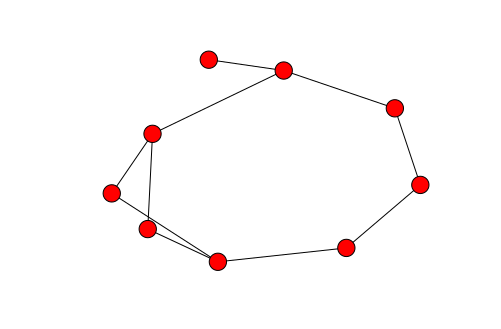

In [10]:
G = nx.Graph()
G.add_edges_from(draw2(0, 'root')[0])

nx.draw(G)
plt.show()

---

# PyGraphviz

In [11]:
import pygraphviz
from IPython.display import Image
from IPython.display import SVG


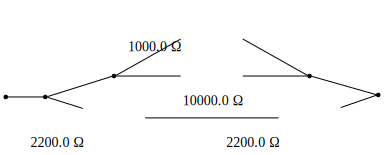

In [12]:
G = pygraphviz.AGraph()
G.graph_attr['rankdir'] = 'LR'
G.add_edges_from(draw2(0, 'dp_0')[0])
G.layout()

point_nodes = filter(lambda node: node.startswith('dp_'), G.nodes())

def style_dp(node_name):
    G.get_node(node_name).attr['shape'] = 'point'
    G.get_node(node_name).attr['width'] = 0.05

def style_resistor(node_name):
    G.get_node(node_name).attr['label'] = ''
    #G.get_node(node_name).attr['label'] = labels[int(node_name)]
    G.get_node(node_name).attr['xlabel'] = '{} Ω'.format(labels[int(node_name)])
    G.get_node(node_name).attr['shape'] = 'none'
    G.get_node(node_name).attr['image'] = 'img/resistor-original.svg'

for node_name in G.nodes():
    if node_name.startswith('dp_'):
        style_dp(node_name)
    else:
        style_resistor(node_name)

SVG(G.draw(format='svg', prog='dot'))

In [13]:
print(G)

strict graph {
	graph [bb="-106.62,-123.43,134.1,156.27",
		rankdir=LR
	];
	node [label="\N"];
	dp_0	 [height=0.5,
		pos="-75.365,138.27",
		shape=point,
		width=0.05];
	dp_9	 [height=0.5,
		pos="-33.038,72.841",
		shape=point,
		width=0.05];
	dp_0 -- dp_9	 [pos="-64.465,121.42 -58.194,111.73 -50.337,99.581 -44.048,89.86"];
	dp_10	 [height=0.5,
		pos="-74.123,-1.54",
		shape=point,
		width=0.05];
	dp_9 -- dp_10	 [pos="-42.567,55.589 -49.157,43.659 -57.894,27.842 -64.504,15.876"];
	5	 [height=0.5,
		image="img/resistor-original.svg",
		label="",
		pos="51.157,78.969",
		shape=none,
		width=0.75,
		xlabel="2200.0 Ω"];
	dp_9 -- 5	 [pos="-4.5331,74.916 4.7219,75.589 14.959,76.335 24.105,77"];
	2	 [height=0.5,
		image="img/resistor-original.svg",
		label="",
		pos="-23.057,-51.439",
		shape=none,
		width=0.75,
		xlabel="1000.0 Ω"];
	dp_10 -- 2	 [pos="-57.966,-17.328 -51.771,-23.381 -44.721,-30.27 -38.586,-36.264"];
	3	 [height=0.5,
		image="img/resistor-original.svg",
		label="",
		pos="-66

---

# Test

In [14]:
edges = [(0, 1), (1, 2), (1, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (7, 9), (6, 10), (10, 11), (11, 12), (11, 13), (13, 14), (14, 15), (15, 16), (15, 17), (14, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (22, 24), (24, 25), (25, 26), (25, 27), (24, 28), (28, 29), (28, 30), (21, 31), (31, 32), (32, 33), (32, 34), (34, 35), (35, 36), (36, 37), (36, 38), (35, 39), (39, 40), (39, 41), (34, 42), (42, 43), (43, 44), (44, 45), (44, 46), (43, 47), (42, 48), (31, 49), (20, 50), (50, 51), (51, 52), (51, 53), (50, 54), (54, 55), (54, 56), (19, 57), (18, 58), (58, 59), (58, 60), (13, 61), (61, 62), (61, 63), (10, 64), (5, 65), (4, 66), (3, 67), (67, 68), (67, 69), (0, 70), (70, 71), (70, 72)]
labels = {0: 'serie', 1: 'paralelo', 2: 2200.0, 3: 'serie', 4: 'paralelo', 5: 'serie', 6: 'serie', 7: 'serie', 8: 2200.0, 9: 2200.0, 10: 'paralelo', 11: 'paralelo', 12: 2200.0, 13: 'serie', 14: 'paralelo', 15: 'serie', 16: 2200.0, 17: 2200.0, 18: 'serie', 19: 'paralelo', 20: 'serie', 21: 'serie', 22: 'paralelo', 23: 2200.0, 24: 'serie', 25: 'serie', 26: 2200.0, 27: 2200.0, 28: 'paralelo', 29: 2200.0, 30: 10000.0, 31: 'paralelo', 32: 'paralelo', 33: 2200.0, 34: 'serie', 35: 'paralelo', 36: 'serie', 37: 2200.0, 38: 10000.0, 39: 'serie', 40: 10000.0, 41: 1000.0, 42: 'paralelo', 43: 'serie', 44: 'serie', 45: 1000.0, 46: 2200.0, 47: 10000.0, 48: 1000.0, 49: 10000.0, 50: 'serie', 51: 'paralelo', 52: 10000.0, 53: 1000.0, 54: 'paralelo', 55: 10000.0, 56: 1000.0, 57: 1000.0, 58: 'paralelo', 59: 2200.0, 60: 10000.0, 61: 'paralelo', 62: 10000.0, 63: 10000.0, 64: 10000.0, 65: 10000.0, 66: 1000.0, 67: 'paralelo', 68: 2200.0, 69: 10000.0, 70: 'serie', 71: 10000.0, 72: 1000.0}

In [15]:
connections = {}

for edge in edges:
    if edge[0] not in connections:
        connections[edge[0]] = []
    connections[edge[0]].append(edge[1])

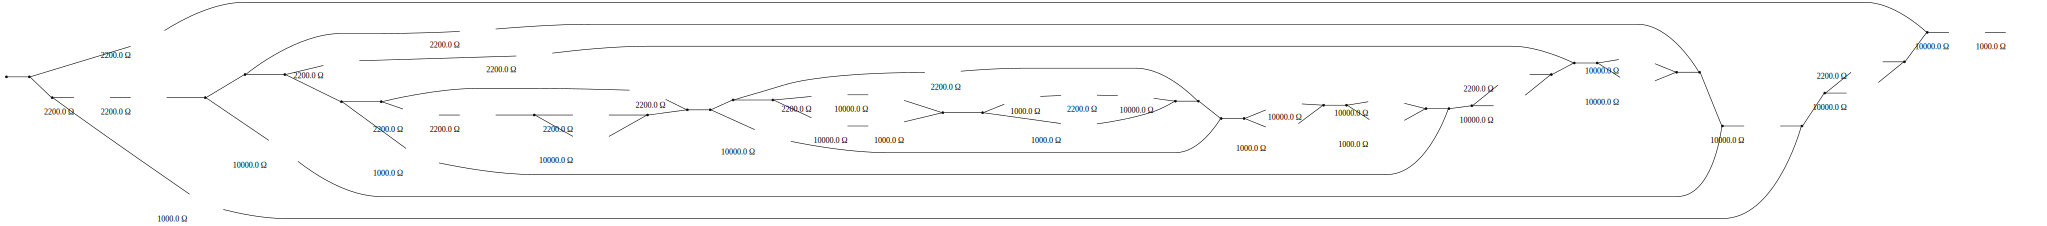

In [16]:
G = pygraphviz.AGraph()
G.graph_attr['rankdir'] = 'LR'
#G.graph_attr['splines'] = 'polyline'  # http://www.graphviz.org/content/attrs#dsplines
#G.graph_attr['splines'] = 'true'

G.add_edges_from(draw2(0, 'dp_0')[0])
G.layout()

point_nodes = filter(lambda node: node.startswith('dp_'), G.nodes())

def style_dp(node_name):
    G.get_node(node_name).attr['shape'] = 'point'
    G.get_node(node_name).attr['width'] = 0.05

def style_resistor(node_name):
    G.get_node(node_name).attr['label'] = ''
    #G.get_node(node_name).attr['label'] = labels[int(node_name)]
    G.get_node(node_name).attr['xlabel'] = '{} Ω'.format(labels[int(node_name)])
    G.get_node(node_name).attr['shape'] = 'none'
    G.get_node(node_name).attr['image'] = 'img/resistor-original.svg'

for node_name in G.nodes():
    if node_name.startswith('dp_'):
        style_dp(node_name)
    else:
        style_resistor(node_name)

SVG(G.draw(format='svg', prog='dot'))
#Image(G.draw(format='png', prog='dot'))

In [17]:
edges = [(0, 1), (1, 2), (2, 3), (2, 4), (1, 5), (5, 6), (5, 7), (0, 8), (8, 9), (9, 10), (9, 11), (8, 12), (12, 13), (12, 14), (14, 15), (15, 16), (16, 17), (16, 18), (15, 19), (14, 20), (20, 21), (21, 22), (22, 23), (22, 24), (21, 25), (25, 26), (26, 27), (26, 28), (25, 29), (20, 30)]
labels = {0: 'serie', 1: 'serie', 2: 'paralelo', 3: 10000.0, 4: 1000.0, 5: 'serie', 6: 10000.0, 7: 1000.0, 8: 'paralelo', 9: 'paralelo', 10: 10000.0, 11: 1000.0, 12: 'paralelo', 13: 10000.0, 14: 'paralelo', 15: 'paralelo', 16: 'paralelo', 17: 2200.0, 18: 2200.0, 19: 1000.0, 20: 'serie', 21: 'paralelo', 22: 'paralelo', 23: 1000.0, 24: 10000.0, 25: 'paralelo', 26: 'paralelo', 27: 1000.0, 28: 10000.0, 29: 1000.0, 30: 10000.0}

In [18]:
connections = {}

for edge in edges:
    if edge[0] not in connections:
        connections[edge[0]] = []
    connections[edge[0]].append(edge[1])

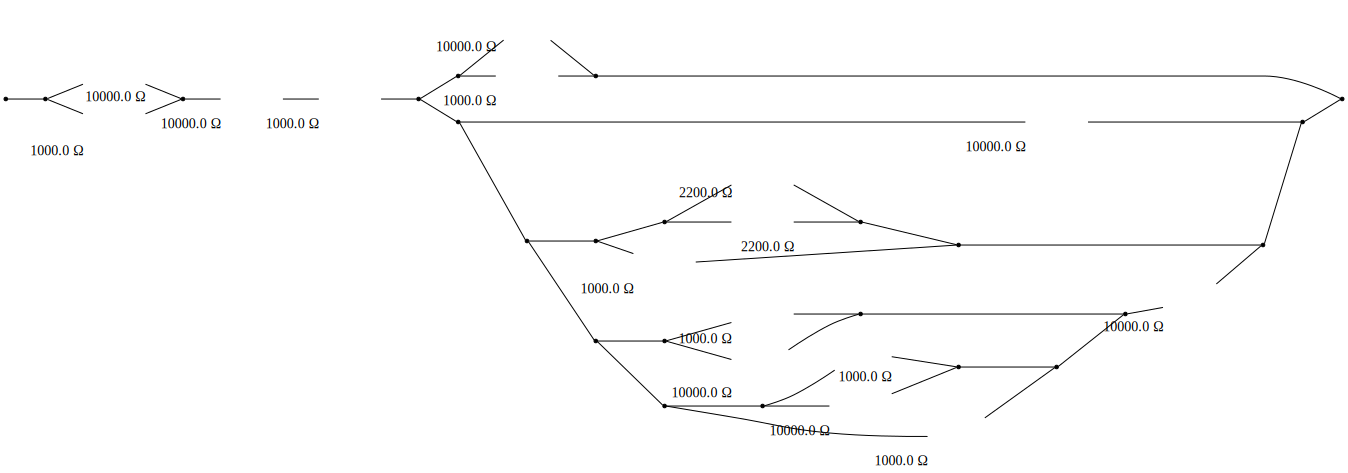

In [19]:
G = pygraphviz.AGraph()
G.graph_attr['rankdir'] = 'LR'
#G.graph_attr['splines'] = 'polyline'  # http://www.graphviz.org/content/attrs#dsplines
#G.graph_attr['splines'] = 'true'

G.add_edges_from(draw2(0, 'dp_0')[0])
G.layout()

point_nodes = filter(lambda node: node.startswith('dp_'), G.nodes())

def style_dp(node_name):
    G.get_node(node_name).attr['shape'] = 'point'
    G.get_node(node_name).attr['width'] = 0.05

def style_resistor(node_name):
    G.get_node(node_name).attr['label'] = ''
    #G.get_node(node_name).attr['label'] = labels[int(node_name)]
    G.get_node(node_name).attr['xlabel'] = '{} Ω'.format(labels[int(node_name)])
    G.get_node(node_name).attr['shape'] = 'none'
    G.get_node(node_name).attr['image'] = 'img/resistor-original.svg'

for node_name in G.nodes():
    if node_name.startswith('dp_'):
        style_dp(node_name)
    else:
        style_resistor(node_name)

SVG(G.draw(format='svg', prog='dot'))
#Image(G.draw(format='png', prog='dot'))

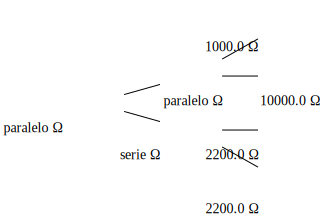

In [20]:
nodes = [0, 1, 2, 3, 4, 5, 6]
edges = (0, 1), (1, 2), (1, 3), (0, 4), (4, 5), (4, 6)
labels = {
    0: 'paralelo',
    1: 'paralelo',
    2: 1000.0,
    3: 10000.0,
    4: 'serie',
    5: 2200.0,
    6: 2200.0
}

from circuit_drawer import GeapGraphGenerator, Graph

Graph(nodes, edges, labels).draw()
#GeapGraphGenerator(nodes, edges, labels).generate()

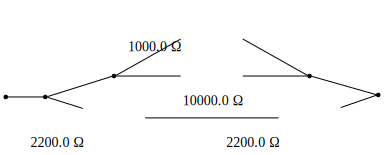

In [21]:
GeapGraphGenerator(nodes, edges, labels).generate().draw()